## Setting

In [2]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
#sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
device = torch.device('cuda')
#device = torch.device('cpu')




import copy
from IPython.display import HTML, display
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))




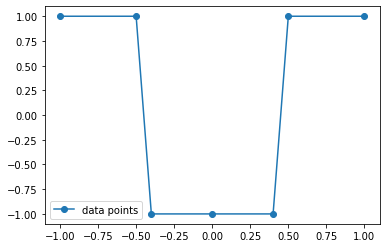

In [3]:
Nmin=-1
Nmax=1
datanumber=7
class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {'data': float(self.data[idx]), 'label': self.label[idx]}
        return sample

    
def fun(x):
    return np.sin(x*np.pi)


data=np.array([-1,-0.5,-0.4,0,0.4,0.5,1])*1.0
label=-(np.array([0,0,1,1,1,0,0])*2.0-1)

train_data=data
train_label=label

plt.plot(train_data,train_label,'-o',label='data points')
plt.legend()
plt.savefig('data_points.png')

train_loader = torch.utils.data.DataLoader(dataset=MyDataset(train_data,train_label), 
                                           batch_size=datanumber, 
                                           shuffle=False)

device = torch.device('cuda')

In [40]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 1

num_classes = 1

NNN=1000

class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet2layer, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1


        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
        stdv = 1. / np.sqrt(self.hidden_size1)
        print(self.hidden_size1)

        #self.fc1.weight.detach().uniform_(-1, 1)
        #self.fc1.bias.detach().uniform_(-1, 1)
        #self.fc2.weight.detach().uniform_(-1/np.sqrt(NNN), 1/np.sqrt(NNN))



        self.fc1.weight.detach().normal_(0, 1)
        self.fc1.bias.detach().normal_(0, 1)
        self.fc2.weight.detach().normal_(0, 1/np.sqrt(NNN))


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/200
        return out

In [41]:
def plot_training(model,node_num=1000):
    plt.plot(train_data,train_label,'x',label=r'$x_j,y_j$')

    
    x= np.linspace(Nmin, Nmax, num=node_num)
    y= np.zeros(node_num)
    with torch.no_grad():
        for i in range(node_num):
            xx=torch.tensor(x[i]).reshape(-1, 1).to(device).float()
            y[i]=model(xx).to(device).cpu().numpy()
    plt.plot(x,y,'-',label=r'$x,f(x)$')
 


def get_line(model,node_num=1000,Nmin=-1, Nmax=1):
    x= np.linspace(Nmin, Nmax, num=node_num)
    y= np.zeros(node_num)
    with torch.no_grad():
        for i in range(node_num):
            xx=torch.tensor(x[i]).reshape(-1, 1).to(device).float()
            y[i]=model(xx).to(device).cpu().numpy()
    return x,y


def modify_init(record_i=1,hidden_size1=20,learning_rate=0.2,epoch=10000,dev=100,gamma=1):
    # hidden_size1=hidden_size1
    # dev=dev
    # learning_rate=learning_rate
    # beta=beta



    torch.manual_seed(1)
    line=[]
    abc=[]
    device = torch.device('cuda')
    model = NeuralNet2layer(1, hidden_size1,1).to(device)
    traj=[]
    with torch.no_grad():
        model.fc1.weight[record_i][0]=1
        model.fc1.bias[record_i]=-0.2
        model.fc2.weight[0][record_i]=1/np.sqrt(NNN)
        model.fc1.weight[:]=gamma*model.fc1.weight[:]
        model.fc1.bias[:]=gamma*model.fc1.bias[:]
        model.fc2.weight[:]=gamma*model.fc2.weight[:]

    


    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    outdis = display(progress(0, 100), display_id=True)
    criterion = nn.MSELoss()

    for i, data in enumerate(train_loader):
        pass
    images = data['data'].reshape(-1, 1).to(device).float()
    labels = data['label'].reshape(-1, 1).to(device).float()
    
    lo=10
    losslist=[]
    for runsteps in range(epoch):
        if runsteps==10000 or runsteps==20000 or runsteps==30000:
            learning_rate = learning_rate * 10
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
            
        if runsteps% dev==0 or lo<0.001:
            outdis.update(progress(outdis.update(progress(100.*runsteps/epoch, 100)), 100))
            

            x=-model.fc1.bias[record_i]/model.fc1.weight[record_i][0].reshape(-1, 1).to(device).float()
            traj.append([x,model(x)])

            a=model.fc1.weight[record_i][0].cpu().detach().numpy()
            b=model.fc1.bias[record_i].cpu().detach().numpy()
            c=model.fc2.weight[0][record_i].cpu().detach().numpy()

            abc.append([a,b,c])
            losslist.append(lo)
            print(runsteps,lo)
        if lo<0.001:
            x,y=get_line(model,node_num=10000)
            line=[x,y]
            print('converged')
            break
    
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()
    return line,abc,traj,losslist

## init

100
1000
10000
100000


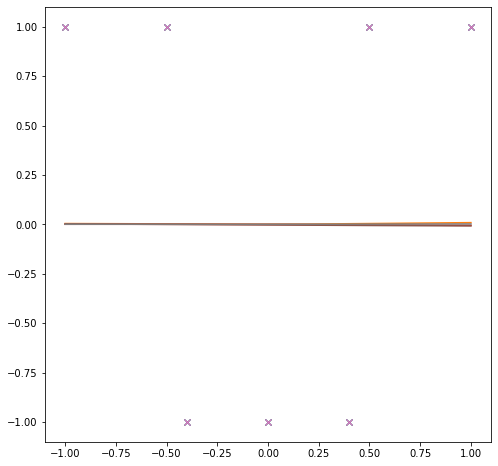

In [42]:
    torch.manual_seed(0)
    batchnorm=False
    device = torch.device('cuda')
    N=[100,1000,10000,100000]
    for n in N:
        model = NeuralNet2layer(input_size, n,num_classes).to(device)
        gamma=(NNN/n)**(1/4)
        record_i=1
        with torch.no_grad():
            model.fc1.weight[record_i][0]=0.5
            model.fc1.bias[record_i]=-0.1
            model.fc2.weight[0][record_i]=0.1/np.sqrt(NNN)
            model.fc1.weight[:]=gamma*model.fc1.weight[:]
            model.fc1.bias[:]=gamma*model.fc1.bias[:]
            model.fc2.weight[:]=gamma*model.fc2.weight[:]
        plot_training(model)

## N variation 

In [48]:
linelist=[]
abclist=[]
trajlist=[]
losslist=[]
N=[100,1000,10000,100000]
for n in N:
    gamma=(NNN/n)**(1/4)
    line,abc,traj,loss=modify_init(hidden_size1=n,learning_rate=0.1,epoch=50000,dev=200,gamma=gamma)
    linelist.append(line)
    abclist.append(abc)
    trajlist.append(traj)
    losslist.append(loss)


100


0 10
200 0.9387121796607971
400 0.8981562256813049
600 0.8497430682182312
800 0.7919389009475708
1000 0.7333499789237976
1200 0.6760900020599365
1400 0.6219252943992615
1600 0.5742738246917725
1800 0.535727322101593
2000 0.5074279308319092
2200 0.4883490800857544
2400 0.47641831636428833
2600 0.46942511200904846
2800 0.46553361415863037
3000 0.46344852447509766
3200 0.4623485803604126
3400 0.46175965666770935
3600 0.46143078804016113
3800 0.46123427152633667
4000 0.4611063003540039
4200 0.46101516485214233
4400 0.4609447121620178
4600 0.46088650822639465
4800 0.46083584427833557
5000 0.4607927203178406
5200 0.4607599973678589
5400 0.46073126792907715
5600 0.4607055187225342
5800 0.46068206429481506
6000 0.46066054701805115
6200 0.4606403708457947
6400 0.46062135696411133
6600 0.46060308814048767
6800 0.46058547496795654
7000 0.46056804060935974
7200 0.4605509340763092
7400 0.4605337679386139
7600 0.4605165421962738
7800 0.4604991674423218
8000 0.46048158407211304
8200 0.460464030504226

0 10
200 0.8811941742897034
400 0.7887423038482666
600 0.6963842511177063
800 0.6148021817207336
1000 0.5521023273468018
1200 0.5108246803283691
1400 0.48663628101348877
1600 0.4738849401473999
1800 0.46754390001296997
2000 0.4644536077976227
2200 0.4629301130771637
2400 0.4621313214302063
2600 0.4616609513759613
2800 0.4613376557826996
3000 0.4610808193683624
3200 0.4608532786369324
3400 0.46063733100891113
3600 0.46042361855506897
3800 0.46020761132240295
4000 0.45998501777648926
4200 0.45975422859191895
4400 0.4595118463039398
4600 0.4592612385749817
4800 0.45900022983551025
5000 0.4587264955043793
5200 0.45844748616218567
5400 0.458157479763031
5600 0.45787739753723145
5800 0.45762190222740173
6000 0.45737722516059875
6200 0.45713189244270325
6400 0.4568798840045929
6600 0.45662182569503784
6800 0.45635685324668884
7000 0.4560837745666504
7200 0.455801784992218
7400 0.4555094838142395
7600 0.4552059471607208
7800 0.4548909664154053
8000 0.45456328988075256
8200 0.45422324538230896


0 10
200 0.7381520867347717
400 0.5960320234298706
600 0.5216687321662903
800 0.48812949657440186
1000 0.47443515062332153
1200 0.4687384366989136
1400 0.4659731388092041
1600 0.46425002813339233
1800 0.46291831135749817
2000 0.4617524743080139
2200 0.46066123247146606
2400 0.45960095524787903
2600 0.45854610204696655
2800 0.4574778079986572
3000 0.45638394355773926
3200 0.455253541469574
3400 0.4540776014328003
3600 0.4528520107269287
3800 0.4515736699104309
4000 0.450246661901474
4200 0.44887661933898926
4400 0.44745948910713196
4600 0.44599810242652893
4800 0.4444938004016876
5000 0.4429570734500885
5200 0.4413977265357971
5400 0.4398232698440552
5600 0.43822604417800903
5800 0.4366048574447632
6000 0.4349554777145386
6200 0.4332887530326843
6400 0.4315991699695587
6600 0.4298888146877289
6800 0.4281603693962097
7000 0.4264257848262787
7200 0.4246828258037567
7400 0.4229191541671753
7600 0.4211362898349762
7800 0.41933271288871765
8000 0.41750481724739075
8200 0.4156496822834015
840

0 10
200 0.5434262156486511
400 0.48450496792793274
600 0.47329989075660706
800 0.46752285957336426
1000 0.4627128541469574
1200 0.4582653045654297
1400 0.4540122151374817
1600 0.44986867904663086
1800 0.44578248262405396
2000 0.44172659516334534
2200 0.437695175409317
2400 0.43368440866470337
2600 0.4297003149986267
2800 0.42574629187583923
3000 0.42182984948158264
3200 0.41795071959495544
3400 0.4141077399253845
3600 0.4102925658226013
3800 0.4065013825893402
4000 0.4027304947376251
4200 0.3989705741405487
4400 0.3952164053916931
4600 0.39146003127098083
4800 0.3876914381980896
5000 0.3839048147201538
5200 0.3800928294658661
5400 0.37625035643577576
5600 0.3723753094673157
5800 0.3684634566307068
6000 0.3645123839378357
6200 0.3605254292488098
6400 0.3565024733543396
6600 0.3524404466152191
6800 0.3483443558216095
7000 0.34421321749687195
7200 0.3400506377220154
7400 0.33585965633392334
7600 0.33164358139038086
7800 0.3274019956588745
8000 0.32313504815101624
8200 0.31884270906448364

Text(0.5, 1.0, 'N=1200,$\\gamma=(N/M)^{1/4}$,scale=0.01,normal')

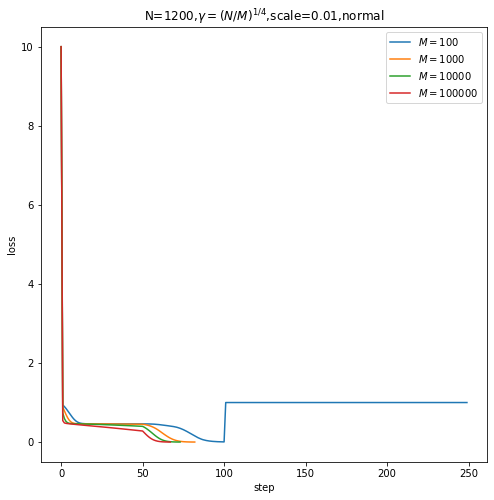

In [49]:
plt.rcParams["figure.figsize"] = (8,8)
c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i in range(len(N)):
    plt.plot(losslist[i],label=r'$M=$'+str(N[i]),color=c[i])
plt.xlabel('step')

plt.ylabel('loss')

plt.legend()
plt.title(r'N=1200,$\gamma=(N/M)^{1/4}$,scale=0.01,normal')
#plt.savefig('/content/drive/My Drive/LCNN/newplots/100.pdf')

In [54]:
plt.rcParams["figure.figsize"] = (8,8)
c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i in range(len(N)):
    plt.plot(linelist[i][0],linelist[i][1],label=r'$M=$'+str(N[i]),color=c[i])
    traj=torch.tensor(trajlist[i]).cpu()
    plt.plot(traj[:,0],traj[:,1],'x-',color=c[i])
plt.plot(train_data,train_label,'x',label=r'$x_j,y_j$')

plt.legend()
plt.title(r'N=1000,$\gamma=(N/M)^{1/4}$,scale=0.01,normal')
plt.savefig('/content/drive/My Drive/LCNN/newplots/n1000_.pdf')

IndexError: ignored

In [27]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")


Mounted at /content/drive
